In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scipy.io
import seaborn as sns
import anndata


import matplotlib.pyplot as plt
%matplotlib inline

save_path = "/home/ubuntu/destVI-paper-code/tumor/spatial/"

### Load data

In [4]:
adata_A = sc.read_visium(save_path + "A1")
adata_A.var_names_make_unique()

adata_B = sc.read_visium(save_path + "B1")
adata_B.var_names_make_unique()

adata = adata_A.concatenate(adata_B, batch_key='batch')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [41]:
adata_A.obsm["spots"] = adata_A.obs[["array_row", "array_col"]].values

(array([150., 198., 253., 291., 247., 286., 289., 254., 164.,  67.]),
 array([ 0. ,  6.8, 13.6, 20.4, 27.2, 34. , 40.8, 47.6, 54.4, 61.2, 68. ]),
 <BarContainer object of 10 artists>)

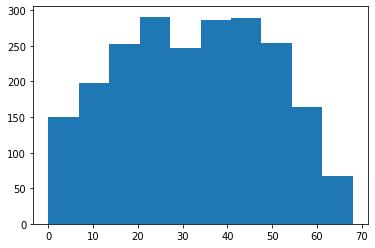

In [51]:
plt.hist(adata_A.obs["array_row"])

(array([113., 225., 246., 255., 259., 262., 253., 239., 231., 116.]),
 array([ 21. ,  29.9,  38.8,  47.7,  56.6,  65.5,  74.4,  83.3,  92.2,
        101.1, 110. ]),
 <BarContainer object of 10 artists>)

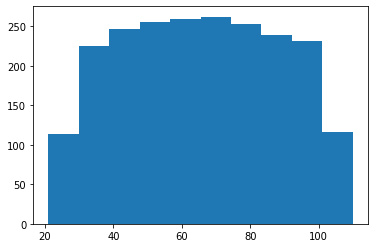

In [52]:
plt.hist(adata_A.obs["array_col"])

In [133]:
# now modify coordinates to fit into a single image
coordinates = np.zeros(shape=(adata.n_obs, 2))
for b in ("0", "1"):
    mask = adata.obs["batch"] == b
    for ax, name in ([0, "x"], [1, "y"]):
        #data = adata[mask].obsm["spatial"][:, ax]
        data = adata[mask].obs[["array_col", "array_row"]].values[:, ax]
        normalized_locations = data - data.min()
        if b == "0" and name == "x":
            normalized_locations -= 120
        if b == "0" and name == "y":
            normalized_locations *= -1
        if b == "1" and name == "y":
            normalized_locations += 5
            normalized_locations *= -1
        coordinates[mask, ax] = normalized_locations
        print(b, name, data.min(), data.max())
        
adata.obsm["location"] = coordinates

0 x 21 110
0 y 0 68
1 x 0 118
1 y 0 51


In [134]:
adata.obs["tumor"] = np.array(["A1" if b == "0" else "B1" for b in adata.obs["batch"]])
adata.obsm["location"] = coordinates

... storing 'tumor' as categorical


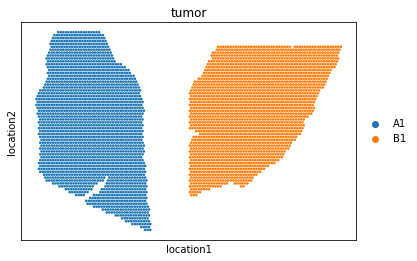

In [135]:
ax = sc.pl.embedding(adata, basis="location", color="tumor", show=False)
#ax.set_aspect(2)

### perform quality control

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("mt")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
adata.obs

,in_tissue,array_row,array_col,batch,tumor,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACAAGTATCTCCCA-1-0,1,50,102,0,A1,5013,8.519989,16702.0,9.723344,22.506287,32.289546,41.797390,54.676087,64.0,4.174387,0.383188
AAACAATCTACTAGCA-1-0,1,3,43,0,A1,8401,9.036225,69610.0,11.150678,26.017814,37.704353,47.853757,59.600632,590.0,6.381816,0.847579
AAACAGAGCGACTCCT-1-0,1,14,94,0,A1,6764,8.819518,36002.0,10.491358,22.332093,33.287040,43.797567,56.885729,184.0,5.220356,0.511083
AAACATTTCCCGGATT-1-0,1,61,97,0,A1,5863,8.676587,24580.0,10.109729,24.617575,35.740439,46.102522,58.425549,128.0,4.859812,0.520749
AAACCGGGTAGGTACC-1-0,1,42,28,0,A1,8132,9.003685,68013.0,11.127469,26.780174,39.449811,50.000735,61.452958,520.0,6.255750,0.764560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1-1,1,24,64,1,B1,5765,8.659734,21602.0,9.980587,22.067401,31.978521,41.778539,54.499583,114.0,4.744932,0.527729
TTGTTCTAGATACGCT-1-1,1,21,3,1,B1,7511,8.924257,43327.0,10.676555,23.421885,33.657996,43.882567,56.336695,232.0,5.451038,0.535463
TTGTTGTGTGTCAAGA-1-1,1,31,77,1,B1,5645,8.638703,20180.0,9.912497,20.460852,30.213082,39.781962,52.621407,81.0,4.406719,0.401388
TTGTTTCCATACAACT-1-1,1,45,27,1,B1,5211,8.558719,19616.0,9.884151,25.627039,34.150693,44.565661,58.100530,1221.0,7.108244,6.224511


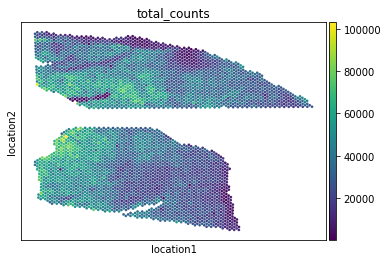

In [8]:
sc.pl.embedding(adata, basis="location", color="total_counts")

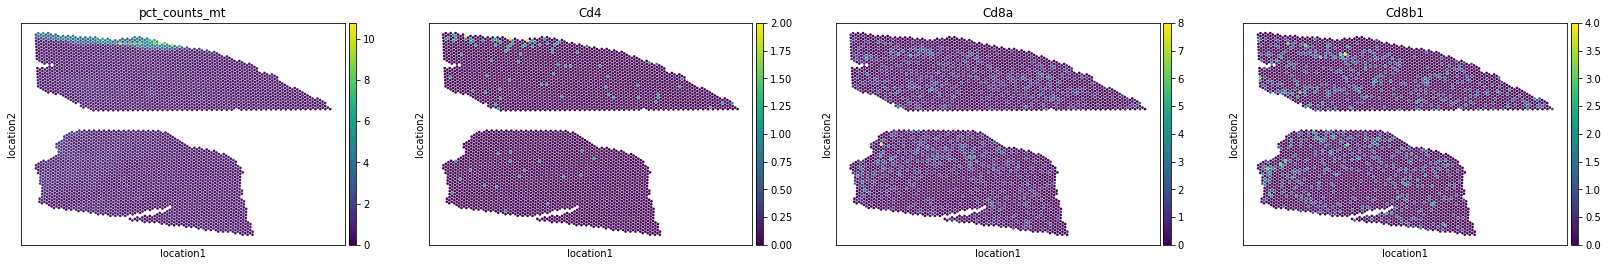

In [13]:
sc.pl.embedding(adata, basis="location", color=["pct_counts_mt", "Cd4", "Cd8a", "Cd8b1"])

In [27]:
adata = adata[adata.obs["pct_counts_mt"] < 2]

In [28]:
adata

View of AnnData object with n_obs × n_vars = 4027 × 16188
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'tumor', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'tumor_colors'
    obsm: 'spatial', 'location'

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

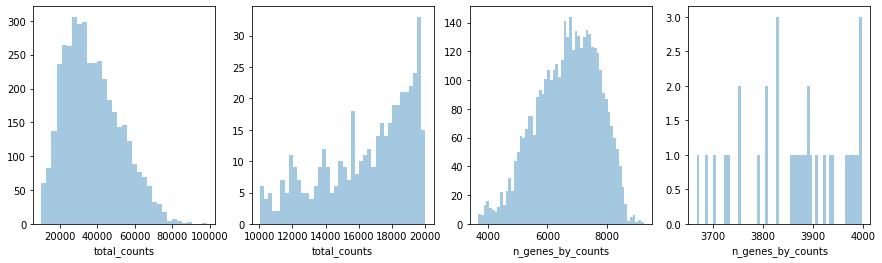

In [29]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
plt.show()

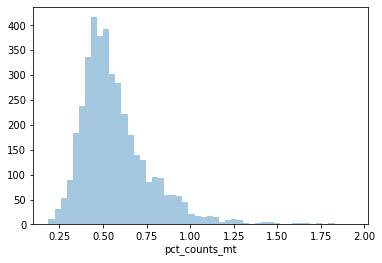

In [30]:
sns.distplot(adata.obs["pct_counts_mt"], kde=False)
plt.show()

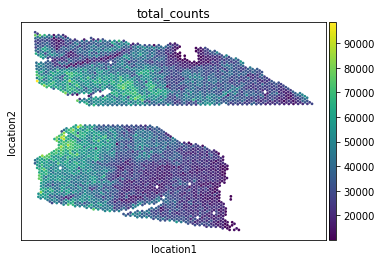

In [31]:
sc.pl.embedding(adata, basis="location", color="total_counts")

In [32]:
sc.pp.filter_cells(adata, min_counts=10000)
sc.pp.filter_cells(adata, max_counts=100000)
print(f"#cells after filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

Trying to set attribute `.obs` of view, copying.


#cells after filter: 4027


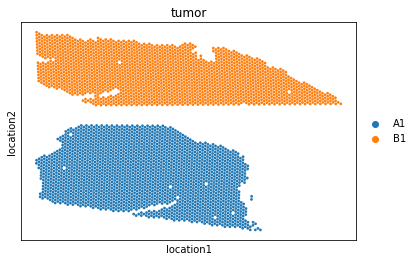

In [33]:
sc.pl.embedding(adata, basis="location", color="tumor")

### Pass through filtering / PCA / UMAP

In [34]:
normalized = adata.copy()
sc.pp.normalize_total(normalized, target_sum=1e4)
sc.pp.log1p(normalized)
sc.pp.highly_variable_genes(normalized, flavor="seurat", n_top_genes=1000)

In [35]:
sc.pp.pca(normalized, svd_solver='arpack')
sc.pp.neighbors(normalized, n_neighbors=10, n_pcs=40)
sc.tl.leiden(normalized, resolution=0.5)
sc.tl.umap(normalized)

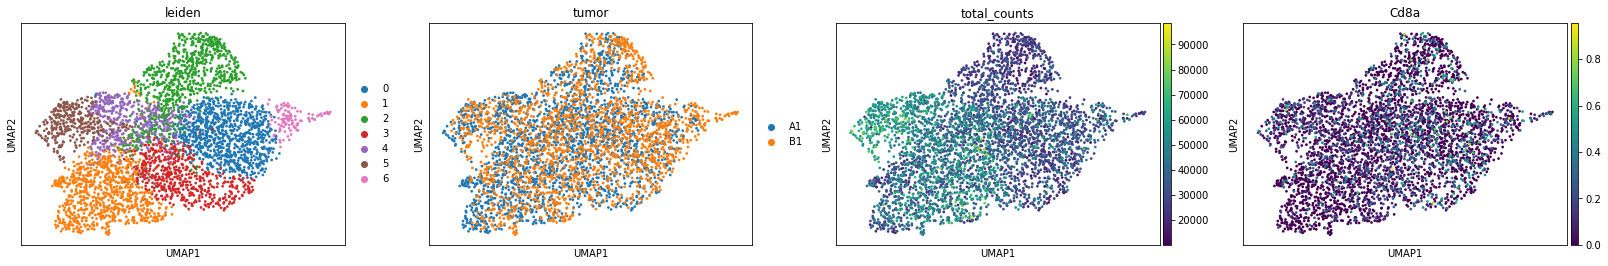

In [36]:
sc.pl.umap(normalized, color=["leiden", "tumor", "total_counts", "Cd8a"])

In [37]:
adata.obsm["X_pca"] = normalized.obsm["X_pca"]
adata.obsm["X_umap"] = normalized.obsm["X_umap"]
adata.obs["leiden"] = normalized.obs["leiden"]

### Select possibly interesting areas

In [40]:
from scipy.spatial import ConvexHull

In [ ]:
# algorithm:
# for each tumor:
#     get convex hull
#     extract simplices of interest
#     for each simplex:
#         cut simplex in grid
#         select two closest spots within the thin tube perpendicular to the simplex
# remove redundant elements
# return list

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


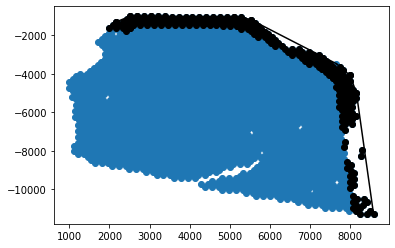

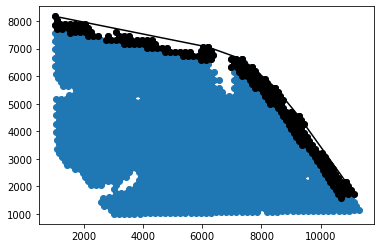

In [191]:
list_ = {}
for tumor, t1, t2 in [("A1", 0, -10000,), ("B1", 10000, 1500)]:
    points = np.array(adata[adata.obs["tumor"] == tumor].obsm["location"])
    hull = ConvexHull(points)

    plt.plot(points[:,0], points[:,1], 'o')
    list_[tumor] = []
    for simplex in hull.simplices:
        # filter only interesting zones
        if np.mean(points[simplex, 0]) + np.mean(points[simplex, 1]) > t1 and np.mean(points[simplex, 1]) > t2:
            # setup the tube
            A = points[simplex[0]] + np.random.normal(0, 1e-6)
            B = points[simplex[1]] + np.random.normal(0, 1e-6)
            AM = A - points
            BM = B - points
            # first get points in the relevant "tube"
            slice_A = np.where(np.dot(AM, (A - B)[:, np.newaxis]) >= -1e-2)[0]
            slice_B = np.where(np.dot(BM, (B - A)[:, np.newaxis]) >= -1e-2)[0]
            slice_ = np.intersect1d(slice_A, slice_B)
            # then isolate based on distance
            cos2_ = np.dot(AM, (A - B)[:, np.newaxis])[:, 0]**2 / (np.sum((A - B)**2) * np.sum(AM**2, axis=1))
            sin2_ = 1 - cos2_
            dist_simplex = np.sqrt(np.sum(AM**2, axis=1) * sin2_)
            # now filter
            slice_ = np.intersect1d(slice_, np.where(dist_simplex < 500))
            list_[tumor].append(slice_)
            plt.plot(points[slice_, 0], points[slice_, 1], "o", c="black")
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    list_[tumor] = np.unique(np.hstack(list_[tumor]))
    plt.show()

In [202]:
list_

{'A1': array([   0,    1,    2,   17,   24,   35,   44,   52,   75,   83,   86,
          92,  100,  110,  112,  114,  122,  135,  151,  160,  162,  169,
         170,  179,  191,  194,  195,  198,  204,  209,  219,  246,  273,
         274,  279,  291,  299,  304,  315,  319,  328,  341,  347,  355,
         364,  365,  375,  379,  380,  383,  387,  394,  403,  415,  455,
         458,  461,  483,  491,  494,  502,  509,  518,  523,  528,  531,
         534,  551,  558,  581,  582,  590,  601,  611,  612,  614,  620,
         622,  626,  628,  649,  655,  674,  678,  681,  708,  710,  731,
         736,  740,  744,  746,  756,  758,  771,  786,  793,  819,  829,
         852,  858,  867,  869,  871,  882,  911,  920,  927,  932,  950,
         953,  960,  963,  965,  971,  974,  989,  991,  999, 1005, 1006,
        1011, 1014, 1026, 1028, 1047, 1062, 1079, 1085, 1095, 1096, 1109,
        1123, 1132, 1156, 1157, 1174, 1188, 1196, 1209, 1210, 1217, 1224,
        1229, 1244, 1265, 1280, 

In [207]:
for tumor in ["A1", "B1"]:
    for x in adata.obs.index[adata.obs["tumor"] == tumor].values[list_[tumor]]:
        print(x)

AAACAAGTATCTCCCA-1-0
AAACAATCTACTAGCA-1-0
AAACAGAGCGACTCCT-1-0
AAATAACCATACGGGA-1-0
AAATGTGGGTGCTCCT-1-0
AACATATCAACTGGTG-1-0
AACCTTTACGACGTCT-1-0
AACGTAGTCTACCCAT-1-0
AAGGAGAACTTATAAG-1-0
AAGTAAGCTTCCAAAC-1-0
AAGTCAATTGTCGTCA-1-0
AAGTTGTGATGTTATA-1-0
AATATCGAGGGTTCTC-1-0
AATGATGCGACTCCTG-1-0
AATGCACCAAGCAATG-1-0
AATGTTGTCGTGAGAC-1-0
AATTTGGGACATAGTA-1-0
ACAATCGATCTTTATA-1-0
ACAGCGCACCCGCAGC-1-0
ACATCTCAACGCGTAA-1-0
ACCAAACTAGAAATCC-1-0
ACCAGCCCGGTCTTTG-1-0
ACCAGGAGTGTGATCT-1-0
ACCCGGATGACGCATC-1-0
ACCTTTCCTTTAGAAG-1-0
ACGAGATATTTGCTTA-1-0
ACGAGTACGGATGCCC-1-0
ACGATCATCTTGTAAA-1-0
ACGCCCAGCTGTCGAT-1-0
ACGCTAGTGATACACT-1-0
ACGTCCTAAACGAGAT-1-0
ACTGTTTAGTGTAGGC-1-0
AGAGGTATCTCGGTCC-1-0
AGAGTAAACTTCACTA-1-0
AGATCGTGCATAAGAT-1-0
AGCATTACGAGGCAAG-1-0
AGCGATGCGCCTAATA-1-0
AGCTAGAAGCAGAAGT-1-0
AGGACGCTCGATGTTG-1-0
AGGCAAAGAGGAATCA-1-0
AGGGAAACGAGGTACT-1-0
AGGTCGCGGAGTTACT-1-0
AGTAGCGTGAACGAAC-1-0
AGTCCCGCCTTTAATT-1-0
AGTGAGCCTCGCCGCC-1-0
AGTGAGTCGAATTAAC-1-0
AGTGTATTGCGCATTG-1-0
AGTTACTCTATCG

### give hotspot a shot

In [38]:
import hotspot
counts = pd.DataFrame(data=adata.X.T.A, columns=adata.obs_names, index=adata.var_names)
pos = pd.DataFrame(
    {
        'X': adata.obsm["location"][:, 0],
        'Y': adata.obsm["location"][:, 1],
    }, index=adata.obs_names
)
num_umi = np.sum(counts, axis=0)


hs = hotspot.Hotspot(counts, model='bernoulli', latent=pos, umi_counts=num_umi)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [39]:
hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head()

100%|██████████| 15976/15976 [00:28<00:00, 567.65it/s]


,C,Z,Pval,FDR
Gene,,,,
Ccl21a,0.352013,88.641348,0.0,0.0
Acta1,0.291485,72.391103,0.0,0.0
Thbs4,0.195468,48.101139,0.0,0.0
Mmp3,0.181320,45.058720,0.0,0.0
Car9,0.181420,45.055481,0.0,0.0


In [87]:
# Select the genes with significant spatial autocorrelation
hs_genes = hs_results.index[hs_results.FDR < 0.0005]

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=4)

  1%|          | 23/2263 [00:00<00:10, 218.74it/s]

Computing pair-wise local correlation on 2263 features...


100%|██████████| 2559453/2559453 [17:08<00:00, 2489.71it/s]


In [88]:
modules = hs.create_modules(
    min_gene_threshold=20, core_only=False, fdr_threshold=0.05
)

modules.value_counts()

 11    254
 7     253
 13    194
 3     149
 4     123
 16    119
 14    100
-1      97
 8      96
 19     87
 12     82
 5      70
 2      64
 1      63
 9      62
 22     59
 21     56
 6      52
 18     38
 15     38
 23     36
 24     33
 25     32
 10     30
 17     30
 20     26
 26     20
Name: Module, dtype: int64

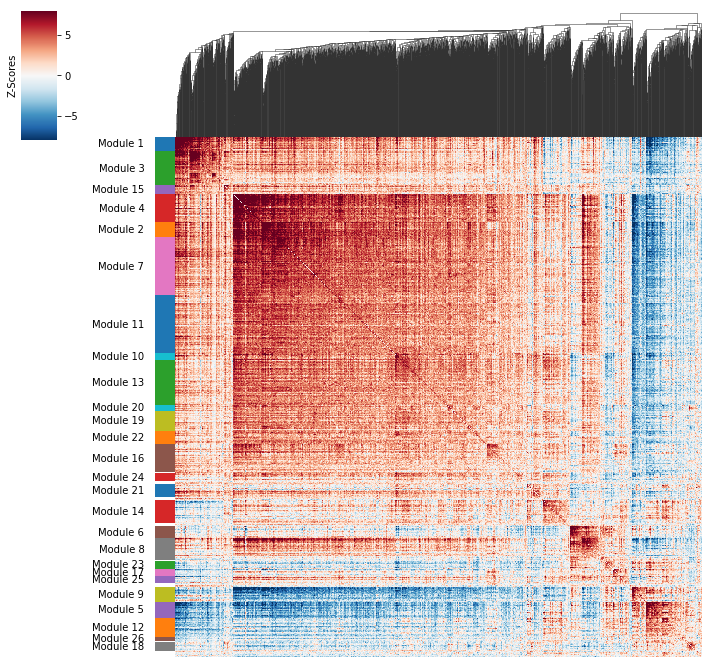

In [89]:
hs.plot_local_correlations()

In [90]:
 # Show the top genes for a module
signature = []
for i in range(1,27):
    print(i)
    module = i
    results = hs.results.join(hs.modules)
    results = results.loc[results.Module == module]
    signature.append("Hotspot_" + str(i) + "\tHotspot\t" + "\t".join(results.sort_values('Z', ascending=False).head(20).index.values))
    print(results.sort_values('Z', ascending=False).head(20))

1
                 C          Z           Pval            FDR  Module
Gene                                                               
Thbs4     0.195468  48.101139   0.000000e+00   0.000000e+00     1.0
Mmp3      0.181320  45.058720   0.000000e+00   0.000000e+00     1.0
Fndc1     0.182889  44.543615   0.000000e+00   0.000000e+00     1.0
Cpxm1     0.177779  44.151090   0.000000e+00   0.000000e+00     1.0
Gpx3      0.164284  40.862889   0.000000e+00   0.000000e+00     1.0
Igfbp5    0.161076  38.372421   0.000000e+00   0.000000e+00     1.0
Mfap5     0.134781  32.652670  3.671851e-234  3.258972e-231     1.0
Col12a1   0.127362  31.463540  1.370280e-217  1.152189e-214     1.0
C1qtnf3   0.117632  29.223962  4.811161e-188  2.745111e-185     1.0
Ccr2      0.116102  28.837260  3.660124e-183  2.016350e-180     1.0
Spon1     0.111644  27.356844  4.476504e-165  2.103430e-162     1.0
Lum       0.096857  23.590196  2.429639e-123  8.821799e-121     1.0
Smoc2     0.095615  22.736217  9.822640e-115  

                C          Z           Pval            FDR  Module
Gene                                                              
Tmsb15a  0.092190  22.495973  2.272531e-112  6.601084e-110    17.0
Fcrl6    0.077356  18.870663   9.939499e-80   1.654098e-77    17.0
Cd55     0.071354  17.345974   1.057801e-67   1.432154e-65    17.0
Gzmc     0.061320  15.010239   3.146036e-51   2.807881e-49    17.0
Il2rb    0.037930   9.379455   3.315736e-21   1.177160e-19    17.0
Car2     0.036934   8.949812   1.780442e-19   5.711714e-18    17.0
Trbc1    0.035386   8.777068   8.389583e-19   2.597519e-17    17.0
Csta2    0.035851   8.720101   1.389770e-18   4.245309e-17    17.0
Dsc2     0.036430   8.581912   4.665439e-18   1.367616e-16    17.0
Jam2     0.035109   8.506401   8.970789e-18   2.586955e-16    17.0
Slamf7   0.033248   8.257991   7.407249e-17   2.029815e-15    17.0
Cst7     0.029523   7.305083   1.385476e-13   3.065701e-12    17.0
Ctsg     0.029958   6.813375   4.766767e-12   9.230773e-11    

In [91]:
#save signatures files
with open("/home/ubuntu/mouse_lymph_node/signatures/Hotspot_tumor.gmt", "w") as text_file:
    text_file.write("\n".join(signature))

In [92]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/26 [00:00<?, ?it/s]

Computing scores for 26 modules...


100%|██████████| 26/26 [00:08<00:00,  3.19it/s]


,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
AAACAAGTATCTCCCA-1-0,-1.213094,-1.249860,-0.899941,1.958543,-0.070755,-1.640930,0.057968,-0.732335,-0.627683,0.407041,...,0.063156,0.712462,-0.447597,0.057479,-0.388459,0.830655,-1.412957,0.478306,-0.460158,0.244705
AAACAATCTACTAGCA-1-0,-0.686979,2.378544,-0.736028,0.626596,-0.370536,-0.707414,1.795713,0.632842,-1.501855,0.766136,...,-1.213939,-0.073949,1.043712,0.981816,-0.223187,0.962912,0.361846,0.681685,-0.088372,-0.442161
AAACAGAGCGACTCCT-1-0,3.188868,2.098491,0.058197,1.405710,-2.971503,-0.017449,2.999947,0.747403,-0.870580,0.838064,...,-0.545789,-0.438740,0.911362,0.594667,0.344398,0.705216,-0.761471,0.732405,-0.419958,-0.320552
AAACATTTCCCGGATT-1-0,-0.497585,-1.439971,-1.155135,0.063434,0.378930,-0.946190,-0.784892,-0.832483,-0.176943,0.288069,...,-0.505920,0.617794,-0.454578,0.072276,0.819501,0.367532,-0.708225,0.271982,-0.498194,0.121899
AAACCGGGTAGGTACC-1-0,-1.036903,-1.479267,-1.168817,-1.027127,1.080027,-1.122333,-1.384914,-1.924409,0.777419,-0.065626,...,1.676841,-0.833276,-0.422880,-0.765913,1.032995,-0.365779,-0.047031,-0.540953,0.239798,-0.540071


In [93]:
module_scores = module_scores.add_prefix('hotspot_')
module_scores.head()

,hotspot_1,hotspot_2,hotspot_3,hotspot_4,hotspot_5,hotspot_6,hotspot_7,hotspot_8,hotspot_9,hotspot_10,...,hotspot_17,hotspot_18,hotspot_19,hotspot_20,hotspot_21,hotspot_22,hotspot_23,hotspot_24,hotspot_25,hotspot_26
AAACAAGTATCTCCCA-1-0,-1.213094,-1.249860,-0.899941,1.958543,-0.070755,-1.640930,0.057968,-0.732335,-0.627683,0.407041,...,0.063156,0.712462,-0.447597,0.057479,-0.388459,0.830655,-1.412957,0.478306,-0.460158,0.244705
AAACAATCTACTAGCA-1-0,-0.686979,2.378544,-0.736028,0.626596,-0.370536,-0.707414,1.795713,0.632842,-1.501855,0.766136,...,-1.213939,-0.073949,1.043712,0.981816,-0.223187,0.962912,0.361846,0.681685,-0.088372,-0.442161
AAACAGAGCGACTCCT-1-0,3.188868,2.098491,0.058197,1.405710,-2.971503,-0.017449,2.999947,0.747403,-0.870580,0.838064,...,-0.545789,-0.438740,0.911362,0.594667,0.344398,0.705216,-0.761471,0.732405,-0.419958,-0.320552
AAACATTTCCCGGATT-1-0,-0.497585,-1.439971,-1.155135,0.063434,0.378930,-0.946190,-0.784892,-0.832483,-0.176943,0.288069,...,-0.505920,0.617794,-0.454578,0.072276,0.819501,0.367532,-0.708225,0.271982,-0.498194,0.121899
AAACCGGGTAGGTACC-1-0,-1.036903,-1.479267,-1.168817,-1.027127,1.080027,-1.122333,-1.384914,-1.924409,0.777419,-0.065626,...,1.676841,-0.833276,-0.422880,-0.765913,1.032995,-0.365779,-0.047031,-0.540953,0.239798,-0.540071


In [94]:
adata.obsm["modules"] = module_scores

In [95]:
del adata.obsm["spatial"]

In [96]:
sc.write(save_path + "save/joint.h5ad", adata)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
